The wavelet transform is implemented in pywt and can be called as follows.

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from solvers import *


Display $f =\Phi u + w$ where $u$ is the camera image and $s$ is some random Gaussian noise.



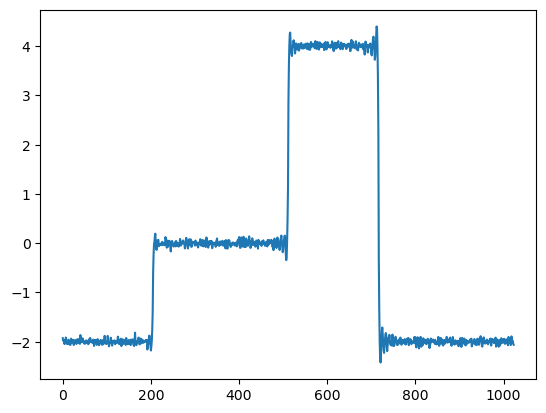

In [2]:
from skimage.util import random_noise
import matplotlib.pyplot as plt


p=1024
s = 4
h = GaussianFilter(s,p)
Phi = lambda x: np.real(ifft(fft(x)*fft(h))); 
Phi_s = lambda x: np.real(ifft(fft(x)*np.conjugate(fft(h))))



mask = np.zeros(p)
mask[:p//8]=np.ones(p//8)
mask[p-p//8:]+=1
mask[np.random.permutation(p)[:p//4]] =  np.ones(p//4)


Phi = lambda x:np.concatenate( ( np.real(mask*fft(x)), np.imag(mask*fft(x))))/np.sqrt(p)
Phi_s = lambda x: np.real(ifft(mask*(x[:p] + 1j*x[p:]))*np.sqrt(p))



t = np.linspace(-2.5, 2.5, p)
x0 = np.piecewise(t, [t < -1.5, t >= 0,t>1], [-2, 4,-2])
b = Phi(x0)

# add noise
sigma = .001;
b = random_noise(b,mode='gaussian',var=sigma,clip=False)

plt.plot(Phi_s(b))

plt.show()



We will consider the regularisation
$$
R_\alpha(f)  := \mathrm{argmin}_u \frac12 \| \Phi u - f\|^2 + \alpha\|W u\|_1
$$
where $W$ is the discrete wavelet transform. Note that since $W^* = W^{-1}$, we can rewrite this as $R_\alpha(f) = W^* z_\alpha$ where
$$
z_\alpha  := \mathrm{argmin}_z \frac12 \| A z - f\|^2 + \alpha\|z\|_1.
$$
where $A:= \Phi\circ W^*$.


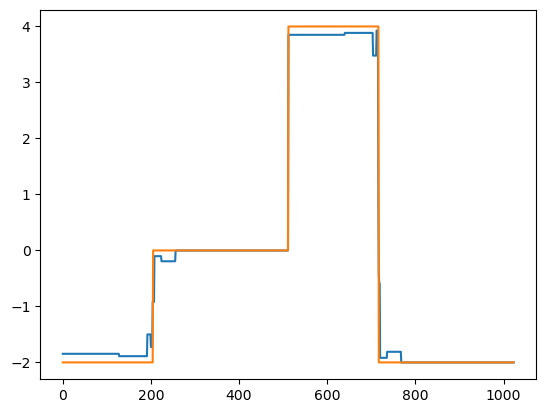

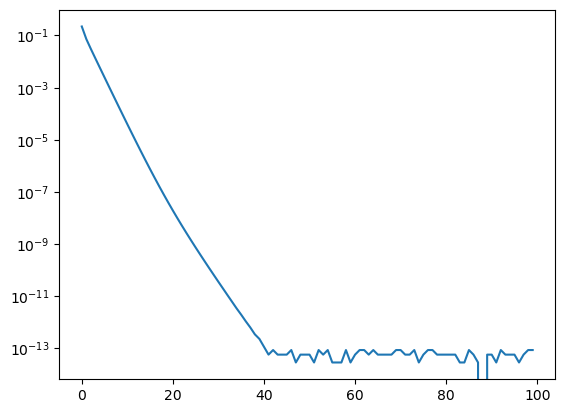

In [3]:
#define the operator A
lev = int(np.log2(p))-1
py_W, py_Ws = getWaveletTransforms(p,wavelet_type = "haar",level = lev)

# Phi o W^{-1}
A = lambda coeffs: Phi(py_Ws(coeffs))

# W o Phi 
As = lambda x: py_W(Phi_s(x))

prox = lambda x, tau: np.maximum(np.abs(x)-tau, np.zeros_like(x))*np.sign(x)

alpha = 1
mfunc = lambda x: .5* np.linalg.norm(A(x)-b)**2 + alpha*np.linalg.norm(x,ord=1)
dG = lambda x: As(A(x) - b)
proxF = lambda x,tau: prox(x,tau*alpha)

tau = 1
nIter =100
xinit = As(b)
x_mode,fval = ISTA(proxF, dG, tau, xinit,nIter,mfunc)
plt.plot(py_Ws(x_mode))
plt.plot(x0)

plt.show()

plt.semilogy(fval-min(fval))


In [ ]:

def generate_samples_x(Iterate,init, n, burn_in=1000):
    x = init

    #burn in 
    for i in range(burn_in):
        x = Iterate(x)
    p = len(x)

    #record n samples
    samples = np.zeros((n,p))
    for i in range(n):
        x = Iterate(x)
        samples[i,:] = x.reshape(-1)
        
    return samples

tau = .001#stepsize
gamma = tau*.01
lam = 1
xinit = As(b)

Iterate = lambda x: prox_langevin(x, dG, tau, gamma, lam, beta=80)

uvinit = np.concatenate((np.abs( np.ones_like(xinit)),As(b)))
Iterate_uv = lambda x: one_step_uv(x, dG, tau, lam, beta=80)

n = 1000
burn_in = 100000

samples = generate_samples_x(Iterate, xinit, n, burn_in)
samples_uv = generate_samples_x(Iterate_uv, uvinit, n, burn_in)
print(samples.shape)

In [ ]:
print(samples.shape)
# plt.plot(py_Ws(samples_uv[70,:502]*samples_uv[70,502:]))

plt.plot(py_Ws(np.mean(samples,axis=0)), 'y')
plt.plot(py_Ws(np.mean(samples_uv[:,:p]*samples_uv[:,p:], axis=0)), 'g')

plt.plot(py_Ws(x_mode), 'k')
plt.plot(x0, 'r')

signal_samples = np.stack([py_Ws(x) for x in samples],axis=0)
signal_samples_uv = np.stack([py_Ws(x) for x in samples_uv[:,:p]*samples_uv[:,p:]],axis=0)

plt.show()

# Calculate 90% credibility intervals (pixel-wise)
lower_bound = np.percentile(signal_samples, 5, axis=0)
upper_bound = np.percentile(signal_samples, 95, axis=0)
plt.plot((upper_bound-lower_bound)**2)


lower_bound = np.percentile(signal_samples_uv, 5, axis=0)
upper_bound = np.percentile(signal_samples_uv, 95, axis=0)
plt.plot((upper_bound-lower_bound)**2, 'm')
